In [ ]:
!pip3 install transformers
!pip3 install datasets

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 39.1 MB/s 
     |████████████████████████████████| 61 kB 539 kB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
     |████████████████████████████████| 3.3 MB 18.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 306 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 132 kB 49.8 MB/s 
     |████████████████████████████████| 243 kB 48.6 MB/s 
     |████████████████████████████████| 192 kB 50.1 MB/s 
     |████████████████████████████████| 271 kB 51.7 MB/s 
     |████████████████████████████████| 160 kB 45.0 MB/s 


In [ ]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import torch
import numpy as np
from transformers import BertTokenizer
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/events.csv")
to_drop = ['sort_order', 'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break']
df.drop(to_drop, axis=1)
df_train = df[["text", "event_type"]]
df_train.isna().sum()

text          0
event_type    0
dtype: int64

In [ ]:
df_train, df_val, df_test = np.split(df_train.sample(frac=1, random_state=42), [int(.8*len(df_train)), int(.9*len(df_train))])

In [ ]:
df_train["event_type"].replace({10: 5, 9:6}, inplace=True)
df_train["event_type"].unique()

array([1, 3, 2, 8, 6, 4, 7, 5])

In [ ]:
df_train["event_type"] = df_train["event_type"] - 1

In [ ]:
model_name = "bert-base-uncased"
max_length = 512

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=11)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from datasets import Dataset

df_train["label"] = df_train["event_type"]
train_dataset = Dataset.from_pandas(df_train[["text","label"]])


In [ ]:
train_dataset = train_dataset.remove_columns('__index_level_0__')

In [ ]:
train_dataset = train_dataset.map(lambda e: tokenizer(e["text"], padding='max_length', truncation=True), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [ ]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert_results", 
    num_train_epochs =5, 
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    logging_dir='./bert_logs',
    logging_steps=10,

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 800
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.067700,0.037765,0.992500
2,0.007400,0.012361,1.000000
3,0.008800,0.004091,1.000000
4,0.004200,0.002943,1.000000
5,0.003800,0.002669,1.000000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to ./bert_results/checkpoint-500
Configuration saved in ./bert_results/checkpoint-50

TrainOutput(global_step=500, training_loss=0.10801842594891786, metrics={'train_runtime': 1047.4109, 'train_samples_per_second': 3.819, 'train_steps_per_second': 0.477, 'total_flos': 1052529266688000.0, 'train_loss': 0.10801842594891786, 'epoch': 5.0})

In [ ]:
df_test["event_type"].replace({10: 5, 9:6}, inplace=True)
df_test["event_type"].unique()
df_test["event_type"] = df_test["event_type"] - 1

In [ ]:
from datasets import Dataset

df_test["label"] = df_test["event_type"]
test_dataset = Dataset.from_pandas(df_test[["text","label"]])

In [ ]:
test_dataset = test_dataset.remove_columns('__index_level_0__')

In [ ]:
test_dataset = test_dataset.map(lambda e: tokenizer(e["text"], padding='max_length', truncation=True), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
pred = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 100
  Batch size = 16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


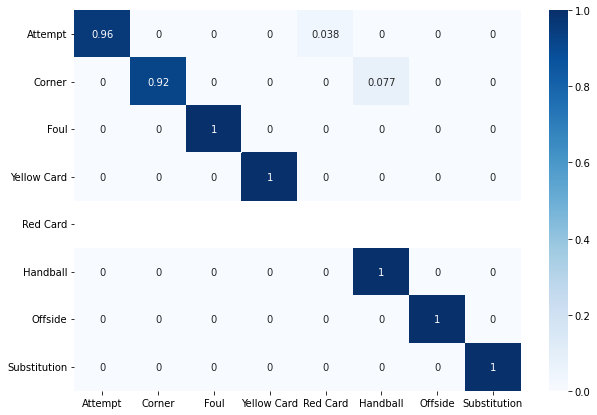

In [ ]:
#Plot the confusion matrix for our predictions
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
df_test["pred"] = pred[1]
labels = ["Attempt", "Corner", "Foul", "Yellow Card", "Red Card", "Handball", "Offside", "Substitution"]
cm = confusion_matrix(df_test["label"], df_test["pred"]) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')